In [1]:
import torch
import numpy as np

from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
train_on_gpu = torch.cuda.is_available()
print("GPU available: ", train_on_gpu)

GPU available:  True


In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
train_data = datasets.CIFAR10('data', train = True, download = True, transform = transform)
test_data = datasets.CIFAR10('data', train = False, download = True, transform = transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)

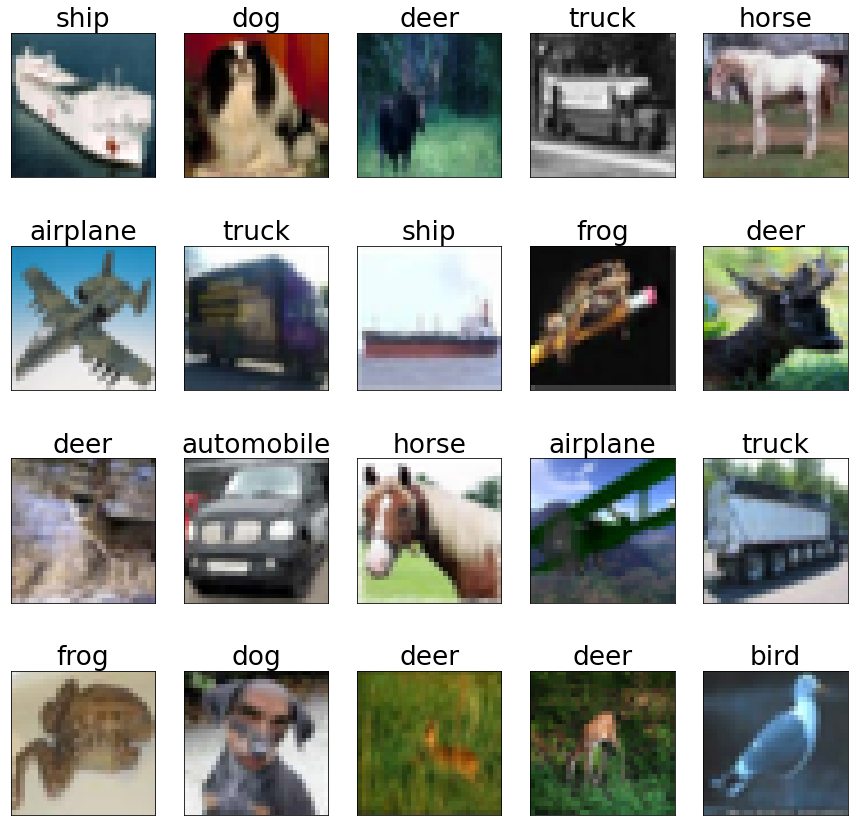

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize = (15,15))
plt.rcParams.update({'font.size': 22})
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks = [])
    unnorm = images[idx] / 2 + 0.5  #to unnormalize
    ax.imshow(np.transpose(unnorm , (1,2,0)))
    ax.set_title(classes[labels[idx]])

(3, 32, 32)


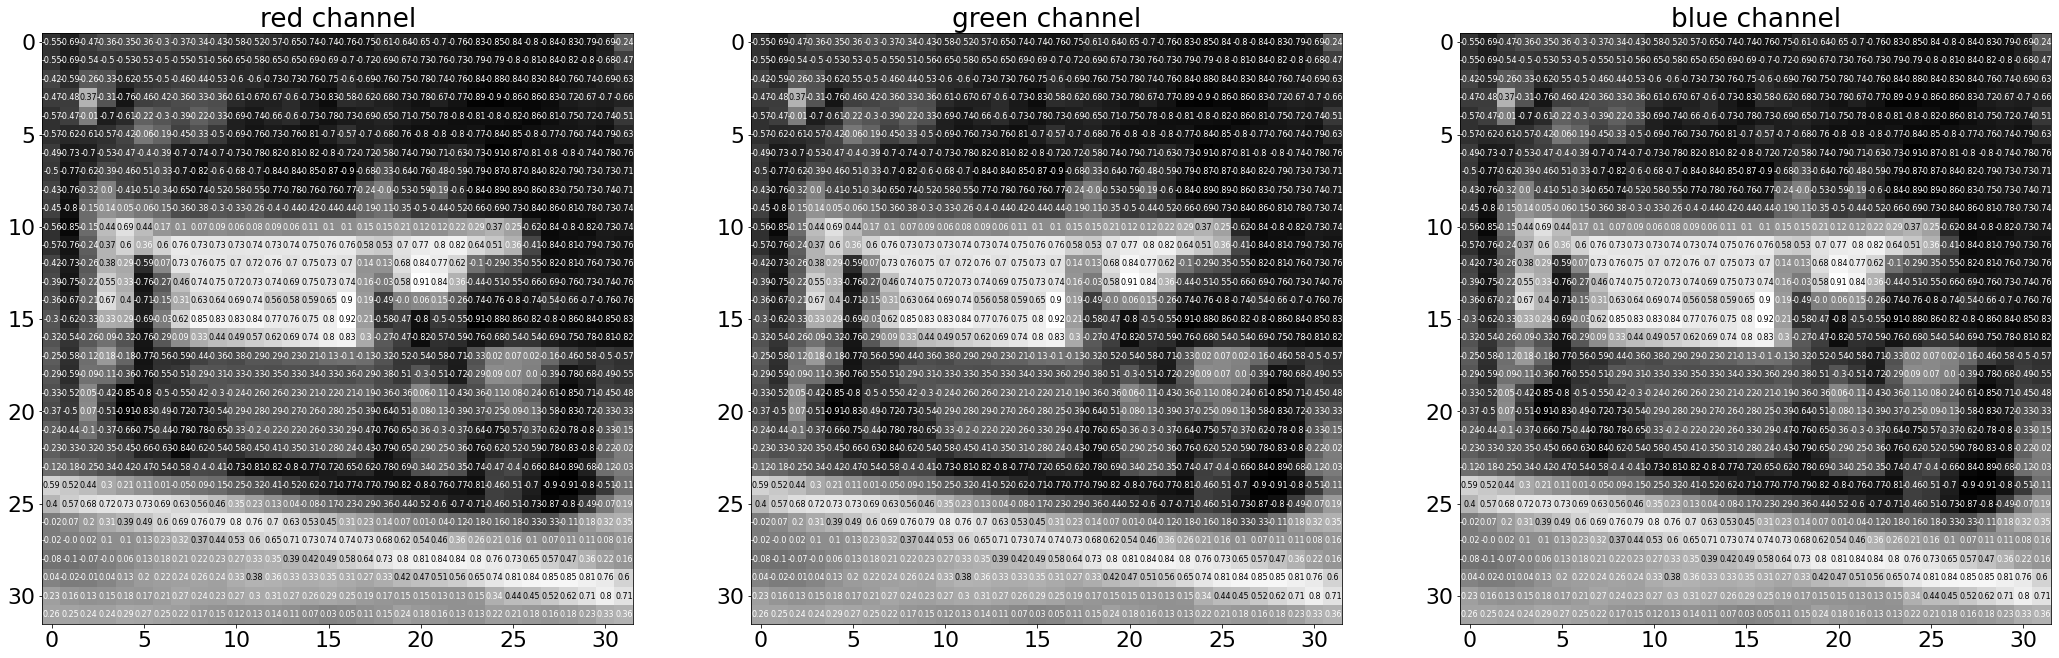

In [7]:
rgb_img = np.squeeze(images[3])
print(rgb_img.shape)
channels = ['red channel', 'green channel', 'blue channel']
fig = plt.figure(figsize=(36,36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1,3, idx+1)
    img = rgb_img[idx]
    ax.imshow(img, cmap = 'gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y], 2) if img[x][y] != 0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment = 'center',
                        verticalalignment = 'center', size = 8,
                        color = 'white' if img[x][y]<thresh else 'black')


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 128)
        self.fc3 = nn.Linear(128, 10)

        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 64*4*4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

model = Network()
print(model)

if train_on_gpu:
    model.cuda()

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [10]:
from torch import optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [21]:
epoches = 50
valid_loss_min = np.Inf

for epoch in range(1 , epoches+1):
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]

    model.eval()
    for images, labels in valid_loader:
        images, labels = images.cuda(), labels.cuda()

        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item() * images.shape[0]

    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    print(f'epoch: {epoch}/{epoches} \tTraining loss: {train_loss:.6f} \tValidation loss: {valid_loss:.6f}')

    if valid_loss<valid_loss_min:
        print("saving the data from {:.6f} ---> {:.6f}".format(valid_loss_min, valid_loss))
        valid_loss_min = valid_loss
        torch.save(model.state_dict(), 'cheackpoint.pt')


epoch: 1/50 	Training loss: 0.776253 	Validation loss: 0.771287
saving the data from inf ---> 0.771287
epoch: 2/50 	Training loss: 0.762683 	Validation loss: 0.777906
epoch: 3/50 	Training loss: 0.754982 	Validation loss: 0.756778
saving the data from 0.771287 ---> 0.756778
epoch: 4/50 	Training loss: 0.745885 	Validation loss: 0.763489
epoch: 5/50 	Training loss: 0.733423 	Validation loss: 0.760876
epoch: 6/50 	Training loss: 0.724494 	Validation loss: 0.748982
saving the data from 0.756778 ---> 0.748982
epoch: 7/50 	Training loss: 0.715649 	Validation loss: 0.732511
saving the data from 0.748982 ---> 0.732511
epoch: 8/50 	Training loss: 0.704142 	Validation loss: 0.736418
epoch: 9/50 	Training loss: 0.700332 	Validation loss: 0.738138
epoch: 10/50 	Training loss: 0.689199 	Validation loss: 0.729037
saving the data from 0.732511 ---> 0.729037
epoch: 11/50 	Training loss: 0.672461 	Validation loss: 0.718536
saving the data from 0.729037 ---> 0.718536
epoch: 12/50 	Training loss: 0.6652

In [22]:
model.load_state_dict(torch.load('cheackpoint.pt'))

<All keys matched successfully>

test loss: 0.676288
Test accuracy of airplane : 76.9
Test accuracy of automobile : 87.81218781218782
Test accuracy of bird : 65.46906187624751
Test accuracy of cat : 58.62412761714855
Test accuracy of deer : 78.28685258964144
Test accuracy of dog : 64.87562189054727
Test accuracy of frog : 83.89662027833002
Test accuracy of horse : 80.53624627606753
Test accuracy of ship : 88.19444444444444
Test accuracy of truck : 84.14271555996035

The overal test accuracy is 76.8840219014435


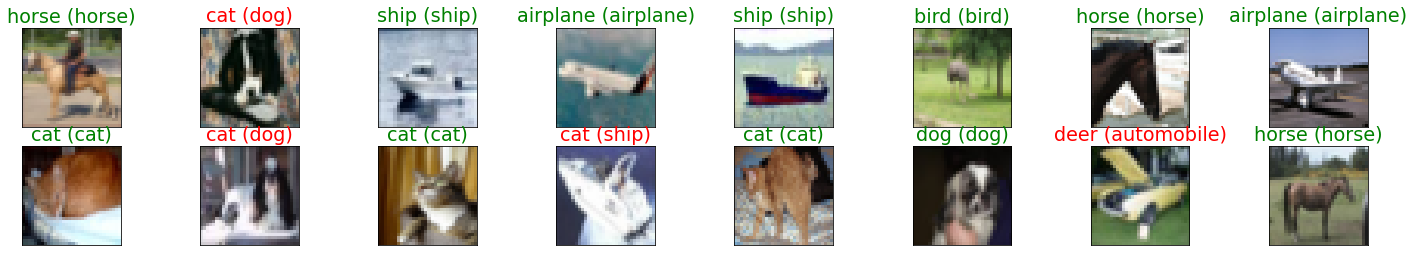

In [23]:
test_loss = 0.0

correct_class = list(i for i in range(10))
total_class = list(i for i in range(10))

model.eval()
for images, labels in test_loader:
    images, labels = images.cuda(), labels.cuda()
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss*images.shape[0]

    _,predict = torch.max(output, 1)
    correct_tensor = predict.eq(labels.data.view_as(predict))
    correct = np.squeeze(correct_tensor.numpy() if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy()))
     
    for i in range(labels.shape[0]):
        label = labels[i]
        correct_class[label] += correct[i].item()
        total_class[label] += 1
    
test_loss = test_loss/len(test_loader.dataset)
print("test loss: {:.6f}".format(test_loss))

fig = plt.figure(figsize=(25, 4))
plt.rcParams.update({'font.size': 16})
for idx in np.arange(labels.shape[0]):
    ax = fig.add_subplot(2, labels.shape[0]/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images.cpu()[idx]/2 +0.5, (1,2,0)))
    ax.set_title("{} ({})".format(classes[predict[idx]], classes[labels[idx]]),
                 color=("green" if predict[idx]==labels[idx].item() else "red"))

for i in range(10):
    if total_class[i] > 0:
        print("Test accuracy of {} : {}".format(classes[i],100 * np.sum(correct_class[i])/np.sum(total_class[i])))
    else:
        print("{} is not tested....".format(classes[i]))

print("\nThe overal test accuracy is {}".format(100*np.sum(correct_class)/np.sum(total_class)))